<a href="https://colab.research.google.com/github/jingxuanf0214/MIT6.484/blob/main/Copy_of_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spring 2022 6.484 Computational Sensorimotor Learning Assignment 8

In this assignment, we will implement Deep Q Network algorithm.

You will need to <font color='blue'>answer the bolded questions</font> and <font color='blue'>fill in the missing code snippets (marked by **TODO**)</font>.

There are (approximately) 140 total points to be had in this PSET.  `ctrl-f` for "pts" to ensure you don't miss questions.

**_Please fill in your name below:_**

**Name**: Jingxuan Fan

For this assignment, you might find GPU machines to be helpful. You can enable GPUs by:

- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

<font color='red'> Make sure you set `show_progress=False` in `dqn_sweep` when you are ready to submit the homework to remove unneccessary outputs.

# Setup

In [ ]:
!pip install gym-minigrid > /dev/null 2>&1

In [ ]:
%matplotlib inline
import numpy as np
import random
import gym
import torch
import seaborn as sns
import gym_minigrid
from tqdm.notebook import tqdm
from dataclasses import dataclass

from torch import nn
import pandas as pd
from torch import optim
from typing import Any
from copy import deepcopy
from gym.wrappers import Monitor
from collections import deque
from gym_minigrid.wrappers import ImgObsWrapper
from gym_minigrid.envs.doorkey import DoorKeyEnv

In [ ]:
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

# set random seed
seed = 0
set_random_seed(seed=seed)



In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
stolen from https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=8nj5sjsk15IT
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env_monitor(env):
  env = Monitor(env, './video', force=True)
  return env

def plot(logs, x_key, y_key, legend_key, **kwargs):
    nums = len(logs[legend_key].unique())
    palette = sns.color_palette("hls", nums)
    if 'palette' not in kwargs:
        kwargs['palette'] = palette
    sns.lineplot(x=x_key, y=y_key, data=logs, hue=legend_key, **kwargs)


class DoorKeyEnv5x5(DoorKeyEnv):
    def __init__(self):
        super().__init__(size=5)
    
    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1

# Task (Environment)

In this assignment, we will work with the `DoorKeyEnv5x5` environment from [gym_miniworld](https://github.com/maximecb/gym-minigrid). This environment is a $5\times 5$ gridworld that we previously used in the policy gradients assignment. The agent needs to pick up the key, open the door, and then go the the green cell. The agent gets a $+1$ reward if it reaches the green cell, and a $0$ reward otherwise.

The environment is visually shown below:

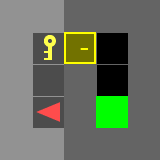


In [ ]:
env = DoorKeyEnv5x5()

In [ ]:
env.action_space

As a refresher, `env.reset()` returns an observation variable, which is a dictionary that contains the current view of the environment (as an image)., agent's facing direction (0: right, 1: down, 2: left, 3: up), and a mission description as a string. The current view of the environment has a similar format as a normal 3-channel image (shape: $7\times7\times3$), but it is not an actual image. The values are not pixels. Each value represents a state of the object on that location. Checkout [the source code](https://github.com/maximecb/gym-minigrid/blob/master/gym_minigrid/minigrid.py) for more details. The action space is $7$-dimensional: 0: turn left, 1: turn right, 2: forward, 3: pickup an object, 4: drop an object, 5: activate an object, 6: done completing task.

# Deep Q Network
In the last assignment, we used tabular Q learning for learning to solve FrozenLake. The tabular approach requires a table to store the $Q$ values for all the possible states and actions pairs. This is only feasible when the state space is discrete and low-dimensional. However, in many more practical domains, the state space is high-dimensional, such as images. For example, in video game environments, each frame can be a state. Even a small change in the pixel value (the agent moves by a little bit) will result in a new state. In such scenarios, it becomes impractical to create a $Q$ table for such a big state space as it would require a huge amount of RAM. To overcome this issue, we will make use of function approximators (e.g., neural networks) to approximate the $Q$ table. This leads to the development of an algorithm called _Deep $Q$ Network (DQN)_. Let's implement this. Feel free to refer to the original [DQN](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf) paper.

## Define the Network architecture

In [ ]:
class DQNetwork(nn.Module):
    def __init__(self, action_dim):
        super().__init__()
        #### A simple convoluntional network that takes
        #### as input the observation (image), and outputs the 
        #### Q values for each possible action.
        self.conv_net = nn.Sequential(
            nn.Conv2d(3, 16, (3, 3)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (3, 3)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (3, 3)),
            nn.ReLU()
        )
        self.fcs = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, ob):
        #### TODO: get the Q values for each action given the input
        #### the input shape is: [batch_size, H, W, 3]
        #### output shape should be: [batch_size, # of actions]
        conv_in = ob.transpose(1, 3).transpose(2, 3)
        #print(conv_in.size())
        intermed = self.conv_net(conv_in)
        #print(intermed.size())
        intermed = torch.flatten(intermed, 1)
        out = self.fcs(intermed)
        #assert False
        return out

**Q1.1 (5 pts)**: What does each argument in `nn.Conv2d(3, 16, (3, 3))` mean?

**A**: 3 means number of channels in the input image: 3 channels usually indicate RGB. 16 means number of channels produced by the convolution. (3, 3) means a square kernel with 3 pixels on each side of the image.

**Q1.2 (10 pts)**: Fill in the missing code for `DQNetwork`.

## Build a replay buffer

**Q2.1 (20 pts)**: Fill in the missing code for `CyclicBuffer`.

In [ ]:
# create a replay buffer
class CyclicBuffer:
    def __init__(self, capacity):
        self.buffer = []
        self.capacity = capacity
        self.cur_pos = 0

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, item):
        return self.buffer[item]

    def append(self, data):
        #### TODO: add data to the buffer
        #### if the buffer is not full yet, you can simply append the data to the buffer
        #### otherwise, you need to replace the oldest data with the current data (FIFO)
        #### Hint: you may find self.cur_pos useful, it can be used as a position index
        #assert False
        #print(len(self.buffer))
        self.cur_pos += 1
        if self.cur_pos>self.capacity:
          self.cur_pos = self.cur_pos - self.capacity
        if len(self.buffer)<self.capacity:
          self.buffer.append(data)
          #self.cur_pos += 1
        else:
          #self.cur_pos = self.cur_pos - self.capacity + 1
          self.buffer[self.cur_pos-1] = data


    def sample(self, batch_size):
        #### TODO: sample a batch from the buffer
        #assert False
        return random.sample(self.buffer, batch_size)

    def get_all(self):
        return deepcopy(self.buffer)

    def clear(self):
        self.buffer.clear()

## Create a DQN agent

Note: In the original DQN paper, the authors proposed to use a hard update on the target $Q$ network every $K$ steps. Later on, people find that using polyak averaging to soft update the target $Q$ network leads to more stable training. We will implement both these ideas in `DQNAgent`.  

In the experiments in the following sections, we will use the soft update scheme to update our target $Q$ network. The soft update has the following formula:
$$\theta_{Q_{tgt}} = \tau\theta_{Q_{tgt}}+(1-\tau)\theta_Q $$

where $\tau$ is typically set to be very close to $1$.

In [ ]:
@dataclass
class DQNAgent:
    env: gym.Env
    learning_rate: float
    gamma: float
    memory_size: int
    initial_epsilon: float
    min_epsilon: float
    max_epsilon_decay_steps: int
    warmup_steps: int
    batch_size: int
    target_update_freq: int
    enable_double_q: bool = False
    disable_target_net: bool = False
    device: str = None
    tau: float = 0.995

    def __post_init__(self):
        self.reset()

    def reset(self):
        if self.device is None:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # self.qnet.to(self.device)
        # self.target_qnet.to(self.device)
        #### TODO: create a Deep Q network instance, 
        #### a replay buffer with capacity=self.memory_size
        #### an Adam optimizer with lr=self.learning_rate.
        #### make sure the networks are on the correct device.
        #### Note that we are using a Huber loss as the loss function (already defined for you)
        self.qnet = DQNetwork(env.action_space.n).to(self.device)
        self.target_qnet = DQNetwork(env.action_space.n).to(self.device)
        self.memory = CyclicBuffer(self.memory_size)
        self.optim = torch.optim.Adam(self.qnet.parameters(), lr=self.learning_rate)
        ####
        self.loss_criterion = nn.HuberLoss()
        self.epsilon = self.initial_epsilon
        self.ep_reduction = (self.epsilon - self.min_epsilon) / float(self.max_epsilon_decay_steps)
        if self.disable_target_net:
            #### TODO: set self.target_update_freq such that the 
            #### target Q network will always be same as the Q network
            #### You don't need to fill in this value until Q4.3
            self.target_update_freq = 1
        
    
    @torch.no_grad()
    def get_action(self, ob, greedy_only=False):
        ob = torch.from_numpy(np.expand_dims(ob, axis=0)).float().to(self.device)
        #print(ob.size())
        q_val = self.qnet(ob)
        #print(q_val)
        action = self.epsilon_greedy_policy(q_val, greedy_only=greedy_only)
        return action

    def epsilon_greedy_policy(self, q_values, greedy_only=False):
        #### TODO: epsilon greedy exploration
        #### we have an extra flag `greedy_only` here, 
        #### if greedy_only is True, then we need to return the action that 
        #### has the maximum Q values.
        #### if greedy_only is False, we do epsilon greedy.
        #assert False
        if greedy_only:
          action = torch.max(q_values, dim=1)[1]
        else:
          if np.random.uniform(0,1) < self.epsilon:
            action = env.action_space.sample()
          else:
            action = torch.max(q_values, dim=1)[1]
        #print(action)
        return action

    def add_to_memory(self, ob, next_ob, action, reward, done):
        #### TODO: add data to the replay buffer
        #assert False
        data = (ob, action, reward, next_ob, done)
        self.memory.append(data)
    
    def update_Q(self):
        # we only start updating the Q network if there are enough samples in the replay buffer
        if len(self.memory) < self.warmup_steps:
            return 0

        #### TODO: sample a batch of data from the replay buffer, and put
        #### them on the correct device. you need to make sure the variables
        #### are in the right tensor shape. (e.g., some scalars might need to be
        #### of shape (batch size, 1) instead of (batch size))
        #print(self.memory)
        sample_batch = self.memory.sample(self.batch_size)
        states = torch.tensor([exp[0] for exp in sample_batch]).float().to(self.device)
        actions = torch.tensor([exp[1] for exp in sample_batch]).long().to(self.device)
        rewards = torch.tensor([exp[2] for exp in sample_batch]).float().to(self.device)
        next_states = torch.tensor([exp[3] for exp in sample_batch if exp[3] is not None]).float().to(self.device)
        done = torch.tensor([exp[4] for exp in sample_batch]).bool().to(agent.device)
        #### TODO: update Q function with Bellman backup
        ##### get Q(s_t, a_t)
        #print(not_done)
        q_val = self.qnet(states).gather(1, actions.unsqueeze(1))
        ##### TODO: get maxQ(s_{t+1}, a_{t+1})
        ##### you will need to implement both DQN and double DQN here
        ##### i.e., you need to check `if self.enable_double_q` in 4.4
        #####
        if self.enable_double_q:
          #assert False
          actions_q = self.qnet(next_states).detach().max(1)[1].unsqueeze(1).long()
          next_state_val = self.target_qnet(next_states).gather(1,actions_q)
        else:
          next_state_val = torch.zeros(self.batch_size, device=self.device)
          next_state_val = agent.target_qnet(next_states).max(1)[0].detach()
        ##### TODO: get the target Q value from the bellman equation
        expected_q_val = (next_state_val * (~done) * agent.gamma) + rewards
        ##### TODO: update the Q network (i.e,. calculate the loss, take a gradient step)
        loss = self.loss_criterion(q_val, expected_q_val.unsqueeze(1))
        self.optim.zero_grad()
        loss.backward()
        for param in self.qnet.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optim.step()
        ######
        #print(loss.item())
        return loss.item()
    
    def decay_epsilon(self):
        #### TODO: linearly decay epsilon
        #### reduce epsilon value by ep_reduction every time the function is called,
        #### make sure epsilon is not smaller than self.min_epsilon
        #assert False
        self.epsilon = max(self.epsilon-self.ep_reduction, self.min_epsilon)
    
    def update_target_qnet(self, step, soft=True):
        if not soft:
            if step % self.target_update_freq == 0:
                #### TODO: update the target Q function in a "hard" way
                #### copy the parameter values in self.qnet into self.target_qnet
                #assert False
                self.target_qnet.load_state_dict(self.qnet.state_dict())
        else:
            #### TODO: soft update on taget Q network.
            #### similar to polyak averaging, we update the target Q network slowly
            #### $\theta_Qtgt = \tau*\theta_Qtgt + (1-\tau)*\theta_Q
            #assert False
            target_q_dict = self.target_qnet.state_dict()
            q_dict = self.qnet.state_dict()
            update_dict = {}
            for param_tensor in target_q_dict:
              update_dict[param_tensor] = self.tau*target_q_dict[param_tensor]+(1-self.tau)*q_dict[param_tensor]
            self.target_qnet.load_state_dict(update_dict)



In [ ]:
config['enable_double_q'] = True
agent = DQNAgent(**config)
doubleq_logs = dqn_sweep([agent], ['double_dqn'], max_steps=1000, show_progress=True)


  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Step:   0%|          | 0/1000 [00:00<?, ?it/s]

Step:249  epsilon:0.9985060000000123  Smoothed Training Return:0.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:972: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


Step:499  epsilon:0.9970060000000247  Smoothed Training Return:0.0
Step:649  epsilon:0.9961060000000321  Smoothed Training Return:0.3333333333333333
Step:899  epsilon:0.9946060000000445  Smoothed Training Return:0.25


In [ ]:
sample_batch = agent.memory.sample(agent.batch_size)
states = torch.tensor([exp[0] for exp in sample_batch]).float().to(agent.device)
actions = torch.tensor([exp[1] for exp in sample_batch]).long().to(agent.device)
rewards = torch.tensor([exp[2] for exp in sample_batch]).float().to(agent.device)
next_states = torch.tensor([exp[3] for exp in sample_batch if exp[3] is not None]).float().to(agent.device)
done = torch.tensor([exp[4] for exp in sample_batch]).bool().to(agent.device)
#### TODO: update Q function with Bellman backup
##### get Q(s_t, a_t)
#print(not_done)
q_val = agent.qnet(states).gather(1, actions.unsqueeze(1))
##### TODO: get maxQ(s_{t+1}, a_{t+1})
##### you will need to implement both DQN and double DQN here
##### i.e., you need to check `if self.enable_double_q` in 4.4
#####
if agent.enable_double_q:
  actions_q = agent.qnet(next_states).detach().max(1)[1].unsqueeze(1).long()
  next_state_val = agent.target_qnet(next_states).gather(1,actions_q)
else:
  next_state_val = torch.zeros(agent.batch_size, device=agent.device)
  next_state_val = agent.target_qnet(next_states).max(1)[0].detach()
##### TODO: get the target Q value from the bellman equation
expected_q_val = (next_state_val * (~done) * agent.gamma) + rewards
##### TODO: update the Q network (i.e,. calculate the loss, take a gradient step)
loss = agent.loss_criterion(q_val, expected_q_val.unsqueeze(1))
agent.optim.zero_grad()
loss.backward()
for param in agent.qnet.parameters():
    param.grad.data.clamp_(-1, 1)
agent.optim.step()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:972: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


**Q3.1 (40 pts)**: Fill in the missing code in `DQNAgent` (you don't need to write the code for double DQN yet).

**Q3.2 (5 pts)**: What is Huber loss? And what's the advantage of using Huber loss compared to MSE loss in updating the $Q$ function?

**A**: Huber loss is a loss function that's defined to be piecewise: if the error is within the range of a small value delta, the loss is quadratic but for larger error the loss is linear. The advantage of Huber loss is that the training is not as affected by outliers as the MSE loss. For the case of updating Q function, HUber loss makes the training more stable and robust to outliers.

## Utils for running experiment

In [ ]:
# you don't need to modify the following code.
@dataclass
class DQNEngine:
    env: gym.Env
    agent: Any
    max_steps: int
    show_progress: bool = False
    show_video: bool = False

    def test(self, env=None, render=False):
        env = self.env if env is None else env
        ob = env.reset()
        ret = 0
        while True:
            if render:
                env.render()
            action = self.agent.get_action(ob, greedy_only=True)
            next_ob, reward, done, info = env.step(action)
            ret += reward
            ob = next_ob
            if done:
                break
        return ret
    
    def run(self, n_runs=1):
        rewards = []
        log = []

        for i in tqdm(range(n_runs), desc='Runs'):
            ep_rewards = []
            ep_steps = []
            self.agent.reset()
            # we plot the smoothed return values
            smooth_ep_return = deque(maxlen=10)
            ob = self.env.reset()
            ret = 0
            num_ep = 0
            for t in tqdm(range(self.max_steps), desc='Step'):
                if len(self.agent.memory) < self.agent.warmup_steps:
                    action = self.env.action_space.sample()
                else:
                    action = self.agent.get_action(ob)
                next_ob, reward, done, info = self.env.step(action)
                true_done = done and not info.get('TimeLimit.truncated', False)
                self.agent.add_to_memory(ob, next_ob, action, reward, true_done)
                self.agent.update_Q()
                ret += reward
                ob = next_ob
                if done:
                    ob = self.env.reset()
                    smooth_ep_return.append(ret)
                    ep_rewards.append(np.mean(smooth_ep_return))
                    ep_steps.append(t)
                    ret = 0
                    num_ep += 1
                    if self.show_progress:
                        print(f'Step:{t}  epsilon:{self.agent.epsilon}  '
                            f'Smoothed Training Return:{np.mean(smooth_ep_return)}')
                    if num_ep % 10 == 0:
                        test_ret = self.test()
                        if self.show_progress:
                            print('==========================')
                            print(f'Step:{t} Testing Return: {test_ret}')
                self.agent.decay_epsilon()
                self.agent.update_target_qnet(t, soft=not self.agent.disable_target_net)

            rewards.append(ep_rewards)
            run_log = pd.DataFrame({'return': ep_rewards,  
                                    'steps': ep_steps,
                                    'episode': np.arange(len(ep_rewards)), 
                                    'epsilon': self.agent.initial_epsilon})
            log.append(run_log)
        return log



def dqn_sweep(agents, labels, n_runs=1, max_steps=1000000, show_progress=False):
    logs = dict()
    for idx, agent in enumerate(tqdm(agents)):
        engine = DQNEngine(env=agent.env, agent=agent, 
                           max_steps=max_steps, show_progress=show_progress)
        ep_log = engine.run(n_runs)
        ep_log = pd.concat(ep_log, ignore_index=True)
        ep_log['Agent'] = labels[idx]
        logs[f'{idx}'] = ep_log
    logs = pd.concat(logs, ignore_index=True)
    return logs


## Run experiments

We have provided for you default hyperparameters to use in `get_default_config` to train your DQN agent. Within 100,000 steps your vanilla DQN should be getting reasonable performance and solving the task (smoothed return for the last 10,000 consecutive episodes is above 0.8). Use the same set of hyperparameters throughout the assignment unless we tell you to modify the config.

You can use `show_progress = True` while testing your code for a faster feedback cycle.

In [ ]:

def get_default_config():
    env = DoorKeyEnv5x5()
    env = ImgObsWrapper(env)
    set_random_seed(0)
    config = dict(
        env=env,
        learning_rate=0.00025,
        gamma=0.99,
        memory_size=200000,
        initial_epsilon=1.0,
        min_epsilon=0.1,
        max_epsilon_decay_steps=150000,
        warmup_steps=500,
        target_update_freq=2000,
        batch_size=32,
        device=None,
        disable_target_net=False,
        enable_double_q=False
    )
    return config

**Q4.1 (5 pts)**: Train your DQN agent and plot its return curve. We have provided you with a `plot` function where the `x_keys` should be `steps`, and `y_keys` should be `return`. Note that `return` corresponds to the return from an episode and that our environment only provides a reward of 1 when the goal is reached.

In [ ]:
config = get_default_config()
agent = DQNAgent(**config)
dqn_logs = dqn_sweep([agent], ['dqn'], max_steps=100000, show_progress=True)

#### TODO: plot the return curves

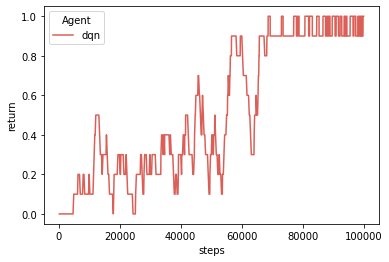

In [ ]:
plot(dqn_logs, 'steps', 'return', 'Agent')

Do we really need a target network? Let's see what if we don't use a target network.

**Q4.2 (10 pts)**: Fill in the missing code in `reset` in `DQNAgent` for the case where we don't use a target Q network (i.e., when `disable_target_net = True`). Plot the return curve for this agent.

In [ ]:
config = get_default_config()
config['disable_target_net'] = True
agent = DQNAgent(**config)
no_tgt_logs = dqn_sweep([agent], ['no_tgt'], max_steps=100000, show_progress=False)

#### TODO: plot the return curves

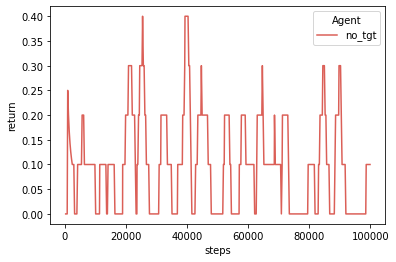

In [ ]:
plot(no_tgt_logs, 'steps', 'return', 'Agent')

Do we really need a replay buffer? Let's see what happens if we do not use a replay buffer. Since we are doing batch update on `Q` function, we can try using a very small replay buffer instead. We can make the size of the replay buffer same as the batch size.

**Q4.3 (10 pts)**: Set the size of the replay buffer and `warmup_steps` to be the same as the batch size in the config. Run the training for this case and plot the return curves.

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Step:   0%|          | 0/100000 [00:00<?, ?it/s]

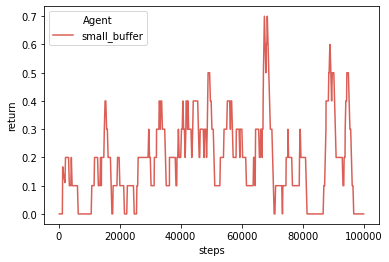

In [ ]:
config = get_default_config()
#### TODO: change some keys in config properly
config['memory_size'] = config['batch_size']
config['warmup_steps'] = config['batch_size']
####
agent = DQNAgent(**config)
small_buffer_logs = dqn_sweep([agent], ['small_buffer'], max_steps=100000, show_progress=False)
#### TODO: plot the return curves
plot(small_buffer_logs, 'steps', 'return', 'Agent')

**Q4.4 (10 pts)**: Fill in the missing code for double DQN in `update_Q` in `DQNAgent` (when `enable_double_q=True`, your code should work for both cases). Train the double DQN agent, and plot the return curve.

In [ ]:
config = get_default_config()
config['enable_double_q'] = True
agent = DQNAgent(**config)
doubleq_logs = dqn_sweep([agent], ['double_dqn'], max_steps=100000, show_progress=True)
#### TODO: plot the return curves

In [ ]:
plot(doubleq_logs, 'steps', 'return', 'Agent')

**Q4.5 (10 pts)**: Plot all the logs (DQN, double DQN, no target network, small replay buffer) in the same figure. Note any differences in success performance between the variants. 

**A**:

**Q4.6 (15 pts)**: Explain why each of our ablations (removing the target network, using a small buffer, and using double DQN) are more or less sucessfull than the vanilla DQN agent.

**A**:

In [ ]:
#### TODO: plot all the logs together


# Survey (bonus, 10 pts)
Please fill out [this anonymous survey](https://docs.google.com/forms/d/e/1FAIpQLSczytsld7GBnGokPzIrSH6zsbmhsOa6ivYYH-01qOianAtRWA/viewform?usp=sf_link) and enter the code below to receive credit. Thanks!

**Bonus code**: double_rainbow_all_the_way

# Submission
Run the below cell to generate an html file with your notebook. You can also follow the piazza instructions for PDF generation

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')
!jupyter nbconvert --to html '/content/drive/My Drive/path_to_notebook.ipynb'